In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Loading the Data

In [3]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

print("Number of training examples:", train_data.shape[0])
print("Number of test examples:", test_data.shape[0])

Number of training examples: 60000
Number of test examples: 10000


**# Separate features and labels**

In [4]:
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

**Normalize the pixel values (scale to [0, 1])**

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

**Convert labels to one-hot encoding**

In [6]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

num_classes = 10
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_test_one_hot = one_hot_encode(y_test, num_classes)

**Split the training data into training and validation sets**

In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train, y_train_one_hot, test_size=0.1, random_state=42
)

## Defining Neural Network Components

**Dense Layer**

In [10]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        # Initialize weights and biases
        self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros((1, output_dim))
        
        # Gradients
        self.dW = None
        self.db = None
        
        # Adam parameters
        self.m_W = np.zeros_like(self.W)
        self.v_W = np.zeros_like(self.W)
        self.m_b = np.zeros_like(self.b)
        self.v_b = np.zeros_like(self.b)
        
        # Cache for backpropagation
        self.input = None
    
    def forward(self, X):
        self.input = X
        output = np.dot(X, self.W) + self.b
        return output
    
    def backward(self, grad_output):
        # Compute gradients
        self.dW = np.dot(self.input.T, grad_output)
        self.db = np.sum(grad_output, axis=0, keepdims=True)
        grad_input = np.dot(grad_output, self.W.T)
        return grad_input
    
    def update_params(self, learning_rate, beta1, beta2, epsilon, t):
        # Update weights and biases using Adam optimizer
        self.m_W = beta1 * self.m_W + (1 - beta1) * self.dW
        self.v_W = beta2 * self.v_W + (1 - beta2) * (self.dW ** 2)
        m_W_hat = self.m_W / (1 - beta1 ** t)
        v_W_hat = self.v_W / (1 - beta2 ** t)
        self.W -= learning_rate * m_W_hat / (np.sqrt(v_W_hat) + epsilon)
        
        self.m_b = beta1 * self.m_b + (1 - beta1) * self.db
        self.v_b = beta2 * self.v_b + (1 - beta2) * (self.db ** 2)
        m_b_hat = self.m_b / (1 - beta1 ** t)
        v_b_hat = self.v_b / (1 - beta2 ** t)
        self.b -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)


**Batch Normalization**

In [11]:
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        self.epsilon = epsilon
        self.momentum = momentum
        
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.zeros((1, input_dim))
        
        # Gradients
        self.dgamma = None
        self.dbeta = None
        
        # Cache for backpropagation
        self.X_centered = None
        self.std_inv = None
        self.batch_mean = None
        self.batch_var = None
        
        # Adam parameters
        self.m_gamma = np.zeros_like(self.gamma)
        self.v_gamma = np.zeros_like(self.gamma)
        self.m_beta = np.zeros_like(self.beta)
        self.v_beta = np.zeros_like(self.beta)
    
    def forward(self, X, training=True):
        if training:
            self.batch_mean = np.mean(X, axis=0, keepdims=True)
            self.batch_var = np.var(X, axis=0, keepdims=True)
            
            self.X_centered = X - self.batch_mean
            self.std_inv = 1.0 / np.sqrt(self.batch_var + self.epsilon)
            
            X_norm = self.X_centered * self.std_inv
            out = self.gamma * X_norm + self.beta
            
            # Update running estimates
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            # Use running mean and var during inference
            X_centered = X - self.running_mean
            std_inv = 1.0 / np.sqrt(self.running_var + self.epsilon)
            X_norm = X_centered * std_inv
            out = self.gamma * X_norm + self.beta
        return out
    
    def backward(self, grad_output):
        N, D = grad_output.shape
        
        # Step-wise computation for gradients
        X_norm = self.X_centered * self.std_inv
        dX_norm = grad_output * self.gamma
        
        dvar = np.sum(dX_norm * self.X_centered * -0.5 * self.std_inv ** 3, axis=0)
        dmean = np.sum(dX_norm * -self.std_inv, axis=0) + dvar * np.mean(-2.0 * self.X_centered, axis=0)
        
        dX = (dX_norm * self.std_inv) + (dvar * 2.0 * self.X_centered / N) + (dmean / N)
        self.dgamma = np.sum(grad_output * X_norm, axis=0, keepdims=True)
        self.dbeta = np.sum(grad_output, axis=0, keepdims=True)
        
        return dX
    
    def update_params(self, learning_rate, beta1, beta2, epsilon, t):
        # Update gamma and beta using Adam optimizer
        self.m_gamma = beta1 * self.m_gamma + (1 - beta1) * self.dgamma
        self.v_gamma = beta2 * self.v_gamma + (1 - beta2) * (self.dgamma ** 2)
        m_gamma_hat = self.m_gamma / (1 - beta1 ** t)
        v_gamma_hat = self.v_gamma / (1 - beta2 ** t)
        self.gamma -= learning_rate * m_gamma_hat / (np.sqrt(v_gamma_hat) + epsilon)
        
        self.m_beta = beta1 * self.m_beta + (1 - beta1) * self.dbeta
        self.v_beta = beta2 * self.v_beta + (1 - beta2) * (self.dbeta ** 2)
        m_beta_hat = self.m_beta / (1 - beta1 ** t)
        v_beta_hat = self.v_beta / (1 - beta2 ** t)
        self.beta -= learning_rate * m_beta_hat / (np.sqrt(v_beta_hat) + epsilon)


**ReLU Activation**

In [12]:
class ReLU:
    def __init__(self):
        self.input = None
    
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)
    
    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input


**Dropout**

In [13]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None
    
    def forward(self, X, training=True):
        if training:
            self.mask = (np.random.rand(*X.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
            return X * self.mask
        else:
            return X  # During inference, no dropout applied
    
    def backward(self, grad_output):
        return grad_output * self.mask


**Softmax and Cross-Entropy Loss**

In [14]:
def softmax_cross_entropy_loss(logits, labels):
    # logits: output of the network before softmax, shape (N, C)
    # labels: one-hot encoded true labels, shape (N, C)
    # returns loss and gradient with respect to logits
    
    # Compute softmax probabilities
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    softmax_probs = exps / np.sum(exps, axis=1, keepdims=True)
    
    # Compute loss
    N = logits.shape[0]
    loss = -np.sum(labels * np.log(softmax_probs + 1e-15)) / N
    
    # Compute gradient
    grad_logits = (softmax_probs - labels) / N
    return loss, grad_logits


## Building the Network Architecture

In [15]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.t = 1  # Timestep for Adam optimizer
    
    def forward(self, X, training=True):
        for layer in self.layers:
            if isinstance(layer, (Dropout, BatchNormalization)):
                X = layer.forward(X, training=training)
            else:
                X = layer.forward(X)
        return X
    
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
    
    def update_params(self, learning_rate, beta1, beta2, epsilon):
        for layer in self.layers:
            if hasattr(layer, 'update_params'):
                layer.update_params(learning_rate, beta1, beta2, epsilon, self.t)
        self.t += 1


In [16]:
input_dim = 784  # 28x28 images flattened
layer1_units = 256
layer2_units = 128
output_units = 10  # Number of classes

layers = [
    DenseLayer(input_dim, layer1_units),
    BatchNormalization(layer1_units),
    ReLU(),
    Dropout(0.2),
    
    DenseLayer(layer1_units, layer2_units),
    BatchNormalization(layer2_units),
    ReLU(),
    Dropout(0.2),
    
    DenseLayer(layer2_units, output_units)
]

# Initialize the network
network = NeuralNetwork(layers)


## Training the Model

**Setting Hyperparameters**

In [17]:
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
num_epochs = 40
batch_size = 64

**Training Loop**

In [18]:
def train(network, X_train, y_train_one_hot, X_val, y_val_one_hot, num_epochs, batch_size):
    num_train_samples = X_train.shape[0]
    num_batches = int(np.ceil(num_train_samples / batch_size))
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Shuffle the training data
        indices = np.arange(num_train_samples)
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_one_hot[indices]
        
        epoch_loss = 0.0
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, num_train_samples)
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            logits = network.forward(X_batch, training=True)
            
            # Compute loss and gradient
            loss, grad_logits = softmax_cross_entropy_loss(logits, y_batch)
            epoch_loss += loss
            
            # Backward pass
            network.backward(grad_logits)
            
            # Update parameters
            network.update_params(learning_rate, beta1, beta2, epsilon)
        
        # Compute average training loss
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        logits_val = network.forward(X_val, training=False)
        val_loss, _ = softmax_cross_entropy_loss(logits_val, y_val_one_hot)
        val_losses.append(val_loss)
        
        # Compute validation accuracy
        predictions = np.argmax(logits_val, axis=1)
        true_labels = np.argmax(y_val_one_hot, axis=1)
        val_accuracy = np.mean(predictions == true_labels)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses


**Training the Network**

In [19]:
train_losses, val_losses = train(
    network, X_train, y_train_one_hot, X_val, y_val_one_hot, num_epochs, batch_size
)

Epoch 1/40, Training Loss: 0.5240, Validation Loss: 0.4045, Validation Accuracy: 0.8455
Epoch 2/40, Training Loss: 0.3972, Validation Loss: 0.3429, Validation Accuracy: 0.8708
Epoch 3/40, Training Loss: 0.3611, Validation Loss: 0.3246, Validation Accuracy: 0.8797
Epoch 4/40, Training Loss: 0.3374, Validation Loss: 0.3181, Validation Accuracy: 0.8840
Epoch 5/40, Training Loss: 0.3164, Validation Loss: 0.3083, Validation Accuracy: 0.8787
Epoch 6/40, Training Loss: 0.3025, Validation Loss: 0.3099, Validation Accuracy: 0.8867
Epoch 7/40, Training Loss: 0.2885, Validation Loss: 0.2904, Validation Accuracy: 0.8922
Epoch 8/40, Training Loss: 0.2790, Validation Loss: 0.3046, Validation Accuracy: 0.8897
Epoch 9/40, Training Loss: 0.2683, Validation Loss: 0.2808, Validation Accuracy: 0.8960
Epoch 10/40, Training Loss: 0.2611, Validation Loss: 0.2958, Validation Accuracy: 0.8940
Epoch 11/40, Training Loss: 0.2522, Validation Loss: 0.2812, Validation Accuracy: 0.8988
Epoch 12/40, Training Loss: 0.

**Evaluating the Model**

In [20]:
def evaluate(network, X_test, y_test_one_hot):
    logits = network.forward(X_test, training=False)
    test_loss, _ = softmax_cross_entropy_loss(logits, y_test_one_hot)
    predictions = np.argmax(logits, axis=1)
    true_labels = np.argmax(y_test_one_hot, axis=1)
    test_accuracy = np.mean(predictions == true_labels)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate(network, X_test, y_test_one_hot)


Test Loss: 0.3208, Test Accuracy: 0.9037


## Saving the Trained Model

In [21]:
import pickle

# Save the model
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(network, f)


**loading the trained model**

In [ ]:
# Load the model
with open('trained_model.pkl', 'rb') as f:
    loaded_network = pickle.load(f)

# Use the loaded model for prediction
logits_test = loaded_network.forward(X_test, training=False)
predictions_test = np.argmax(logits_test, axis=1)


**Visualizing Training Progress**

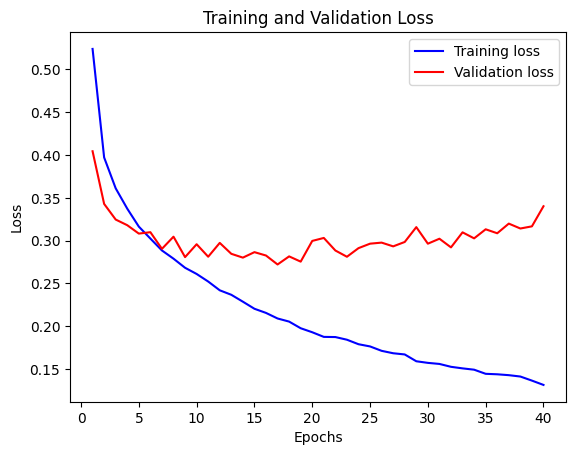

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
